In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os 
os.chdir("drive/MyDrive/protein-embedding-02456-2020/notebooks")

In [4]:
! pip install Biopython

     |████████████████████████████████| 2.3MB 7.8MB/s 


# Training using LSTM 

In [5]:
# import general libraries
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
from IPython import display

# import my functions
from training_functions import Dataset, my_collate
from data_functions import get_inputs_targets_from_sequences,\
 get_train_test, organize_fasta_header, IUPAC_VOCAB
from networks import Gru

In [11]:
# read in table from uniprot with info and sequences
#name = "bal900-beta-lactamase"
#data=pd.read_csv("data_small/balanced900_pfam_uniprot_BL.tsv",sep='\t') #make sure you have updated the value above 
name = "LSTM_CytoC-betalactamase"
data = pd.read_csv("data_small/BL-cytoC_mix.tsv",sep='\t')
n_seq=data.shape[0]
data.head(n=2)
data["Protein families"].value_counts()

Cytochrome c family                                                  4634
Cytochrome c family, PsbV subfamily                                  1005
Cytochrome c family, PetJ subfamily                                   986
Class-D beta-lactamase family                                         900
Metallo-beta-lactamase superfamily, Glyoxalase II family              900
Class-C beta-lactamase family                                         900
Metallo-beta-lactamase superfamily, Class-B beta-lactamase family     900
Hcp beta-lactamase family                                             900
Binding-protein-dependent transport system permease family            900
Peptidase S12 family, YfeW subfamily                                  900
Class-A beta-lactamase family                                         900
LysR transcriptional regulatory family                                900
Name: Protein families, dtype: int64

In [13]:
# get indices for train/test split
train_idx, test_idx=get_train_test(list(range(n_seq)), list(range(n_seq)), train_frac=0.8)
#group=["Cytochrome c family", "Cytochrome c family, PsbV subfamily", "Cytochrome c family, PetJ subfamily"]
#idx=[i for i, e in enumerate(data["Protein families"]) if e in group]

#test_table=data.iloc[idx]
#train_table = data.drop(idx, axis=0)

# select train/test splits in table
train_table = data.iloc[train_idx[0]]
test_table = data.iloc[test_idx[0]]

# add <unk> and quote each letter #
# train 
train_seq=train_table["Sequence"].to_list()
train_seq=[list(seq) for seq in train_seq] 
_=[seq.append("<unk>") for seq in train_seq]


# test 
test_seq=test_table["Sequence"].to_list()
test_seq=[list(seq) for seq in test_seq]
_=[seq.append("<unk>") for seq in test_seq]

## get inputs and targets 
inputs_train, targets_train=get_inputs_targets_from_sequences(train_seq)
inputs_test, targets_test=get_inputs_targets_from_sequences(test_seq)

In [14]:
# convert AA to letters using dictionary
# targets =Y, inputs = X
# train 
targets_train_num = [torch.tensor([IUPAC_VOCAB[i] for i in sequence]) for sequence in targets_train]
inputs_train_num = [torch.tensor([IUPAC_VOCAB[i] for i in sequence]) for sequence in inputs_train]
# test - for estimation of test error 
targets_test_num = [torch.tensor([IUPAC_VOCAB[i] for i in sequence]) for sequence in targets_test]
inputs_test_num = [torch.tensor([IUPAC_VOCAB[i] for i in sequence]) for sequence in inputs_test]
# test for investigaing embedding 
test_full_seq = [torch.tensor([IUPAC_VOCAB[i] for i in sequence]) for sequence in test_seq]

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [16]:
len(targets_train)

11780

In [17]:
len(inputs_test)

2945

# Train LSTM

In [18]:
import torch.nn.functional as F

class lstm_net(nn.Module):
    def __init__(self, vocab, n_layers, hidden_size, batch_size, embedding_dim=10):
        super(lstm_net, self).__init__()
        self.vocab_size=len(vocab.values())
        self.vocab = vocab
        self.n_layers=n_layers
        self.hidden_size = hidden_size
        self.batch_size=batch_size
        self.dropout = nn.Dropout(p=0.5)
        self.embedding_dim = embedding_dim

        padding_idx = self.vocab['<pad>']
        self.word_embedding = nn.Embedding(
            num_embeddings=self.vocab_size,
            embedding_dim=self.embedding_dim,
            padding_idx=padding_idx)

        self.lstm=nn.LSTM(input_size=self.embedding_dim, hidden_size=self.hidden_size, num_layers=self.n_layers, dropout=0.5)

        self.l_out = nn.Linear(in_features=self.hidden_size,
                            out_features=self.vocab_size,
                            bias=False)
       
        
    def forward(self, x):
        """x: packed sequence"""
        
        ps=None
        if type(x)==torch.nn.utils.rnn.PackedSequence:
            ps=True
            x, seq_len= torch.nn.utils.rnn.pad_packed_sequence(x, batch_first=False)
        
        x = self.word_embedding(x)

        if ps:
            x=torch.nn.utils.rnn.pack_padded_sequence(x, seq_len, enforce_sorted=False)
        
        if not ps:
            x=x.reshape(-1,1,self.embedding_dim)


        # RNN returns output and last hidden state
        cs, h = self.lstm(x)
        x=cs
        # tilføj relu
        
        if type(x)==torch.nn.utils.rnn.PackedSequence:
            x, seq_len= torch.nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
        
        x=F.relu(x)

        #x = x.contiguous()
        #X = X.view(-1, X.shape[2])
        # Flatten output for feed-forward layer
        x = x.view(-1, self.lstm.hidden_size)
        #print(x.shape)
        # Output layer
        x = self.l_out(x)
        #print(x.shape)
        #x = x.view(self.batch_size, max(seq_len), self.vocab_size)
        x = x.view(-1, self.vocab_size)
        x = F.log_softmax(x, dim=1)

        # print(x.shape)
        return x, h

In [19]:
# prepare training and test data 
train_size = len(inputs_train)
test_size=len(inputs_test)
batch_size=32
train1 = Dataset(inputs_train_num, targets_train_num)
test1 = Dataset(inputs_test_num, targets_test_num)
# we define the dataloader for the training data 
trainloader = DataLoader(train1,
                      batch_size=batch_size,
                      shuffle=False,
                      collate_fn=my_collate, # use custom collate function here
                      pin_memory=True)

testloader = DataLoader(test1,
                      batch_size=batch_size,
                      shuffle=False,
                      collate_fn=my_collate, # use custom collate function here
                      pin_memory=True)

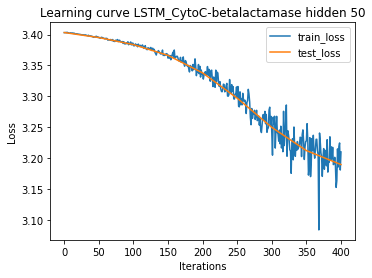

In [ ]:
# set initialvalues 
vocab_size=len(IUPAC_VOCAB)
n_layers=10
hidden_size=50
max_iter = 1000
eval_every = 50
log_every=100

# define the neural network
#net = Gru(n_layers=n_layers, hidden_size=hidden_size, batch_size=batch_size, vocab=IUPAC_VOCAB)
net = lstm_net(vocab=IUPAC_VOCAB, n_layers=n_layers, hidden_size=hidden_size, batch_size=batch_size)
net.to(device)

# define loss and optimizer 
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=0.00001)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.00001) # orig: momentum=0.9

# Track loss
stats = { 'test_loss': [], "train_loss":[], "test_iter":[], "train_iter":[], "test_loss_all":[]} 

i=0
while i<max_iter:
  for inputs, targets, data in trainloader:

        if i % eval_every == 0:
          sum_loss_test=0
          #print("sum_loss_test: {}".format(sum_loss_test))

          net.eval()
          # For each sentence in validation set
          for inputs_test, targets_test, data_test in testloader:
              inputs_test, targets_test = inputs_test.to(device), targets_test.to(device)
              outputs, h=net(inputs_test)

              #h_test, c0_test = h.cuda(), c.cuda()

              #print(outputs.shape)
              # reshape the targets for use in loss function
              targets_test_f=[item for sublist in targets_test for item in sublist]
              targets_test_flat = torch.LongTensor(targets_test_f).to(device)  
        
              tag_pad_token=0
              mask = (targets_test_flat > tag_pad_token).float()
              nb_tokens = int(torch.sum(mask).item())
  
              # pick the values for the label and zero out the rest with the mask
              outputs = outputs[range(outputs.shape[0]), targets_test_flat] * mask
              #print(outputs.shape)
              # compute cross entropy loss which ignores all <PAD> tokens
              loss_test = -(torch.sum(outputs) / nb_tokens)
              #print(loss_test)
              # Update loss
              sum_loss_test += loss_test.detach().cpu().numpy()
              #print(sum_loss_test)
              #stats["test_loss_all"].append(loss_test)
              
          stats["test_iter"].append(i)
          #stats["test_iter"].append(i)
          stats["test_loss"].append(sum_loss_test/len(testloader))
          


        ###########
        # TRAIN
        ###########
        net.train()
        optimizer.zero_grad() 

        inputs, targets = inputs.to(device), targets.to(device)

        # predict using the model 
        outputs, h=net(inputs)
        
        # reshape the targets for use in loss function
        targets_f=[item for sublist in targets for item in sublist]
        targets_flat = torch.LongTensor(targets_f).to(device) 
        
        
        tag_pad_token=0
        mask = (targets_flat > tag_pad_token).float()
        nb_tokens = int(torch.sum(mask).item()) # data[0]
        # pick the values for the label and zero out the rest with the mask
        outputs = outputs[range(outputs.shape[0]), targets_flat] * mask
        loss = -(torch.sum(outputs) / nb_tokens)
        
        # Backward pass
        loss.backward() # get gradients 
        optimizer.step()
        
        # Update loss
        #epoch_training_loss += loss.detach().cpu().numpy()
        stats["train_loss"].append(loss.detach().cpu().numpy())
        stats["train_iter"].append(i)

        # Print loss every 10 iterations
        #if i % 10 == 0:
        #  print(f'Iter {i}, training loss: {stats["train_loss"][-1]}, test loss: {stats["test_loss"][-1]}')


        # Log i figure
        if i % log_every == 0:
          fig = plt.figure(figsize=(12,4))
          plt.subplot(1, 2, 1)
          plt.title("Learning curve {} hidden {}".format(name, hidden_size))
          plt.plot(stats["train_iter"], stats["train_loss"], label='train_loss')
          plt.plot(stats["test_iter"], stats["test_loss"], label='test_loss')
          plt.legend()
          plt.xlabel('Iterations')
          plt.ylabel('Loss')
          fig.savefig("visualization/learning_curves/2nd_CE_{}".format(name))
          plt.show()
          display.clear_output(wait=True)

          #print(f'Iter {i}, training loss: {stats["train_loss"][-1]}, test loss: {stats["test_loss"][-1]}')
          #print("Train, it: {} loss: {:.2f} accs: {:.2f}".format(i, train_loss[-1], train_accs[-1]))

        if i>max_iter:
          break
        i+=1


In [ ]:
import pandas as pd
test_table_num=test_table.to_numpy()

# save the trained network for later 
PATH = '{}_b_{}_train{}_iter{}_hidden{}.pth'.format(name, batch_size, train_size, max_iter,hidden_size)
print(PATH)

ONLYLSTM_bal900-beta-lactamase_b_32_train4320_iter1000_hidden5.pth


In [ ]:
#torch.save({
#    'state_dict':   net.state_dict(), 
#    'stats':        stats,
#    'args':         {"batch_size": batch_size, "n_layers":n_layers, "hidden_size":hidden_size, "vocab":IUPAC_VOCAB},
#    'test_full':    test_full_seq,
#    "test_table":    (test_table_num,test_table.columns),
#    "train_info":   {"optim":optimizer, "max_iter":max_iter},
#    "train_size":   train_size,
#    "train_idx":    train_idx,
#    "test_idx":     test_idx,
#},  "models/{}".format(PATH), _use_new_zipfile_serialization=False)

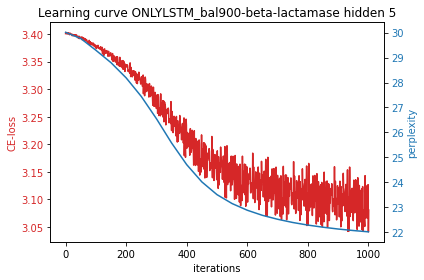

In [ ]:
# x-axis 
iter = stats["train_iter"]

# Create some mock data
val_perplexity = np.exp(stats["test_loss"])

fig, ax1 = plt.subplots()
plt.title("Learning curve {} hidden {}".format(name, hidden_size))

color = 'tab:red'
ax1.set_xlabel('iterations')
ax1.set_ylabel('CE-loss', color=color)
ax1.plot(iter, stats["train_loss"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('perplexity', color=color)  # we already handled the x-label with ax1
ax2.plot(stats["test_iter"], val_perplexity, color=color)
ax2.tick_params(axis='y', labelcolor=color)
#plt.title("Learning curve {}".format("name")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.xlim(0,200)
#plt.show()
plt.savefig("visualization/learning_curves/train_{}_hidden{}".format(name, hidden_size))

# Embeddings


In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns 

In [ ]:
pth=torch.load("models/{}_b_{}_train{}_iter{}_hidden{}.pth".format(name,batch_size, train_size, max_iter, hidden_size), map_location=torch.device('cpu'))

In [ ]:
stats = pth["stats"]
test_info = pd.DataFrame(pth["test_table"][0], columns=pth["test_table"][1])
test = pth["test_full"]
n_layers = pth["args"]["n_layers"]

In [ ]:
net=lstm_net(**pth["args"])
net.load_state_dict(pth["state_dict"])
net.eval()

lstm_net(
  (dropout): Dropout(p=0.5, inplace=False)
  (word_embedding): Embedding(30, 10, padding_idx=0)
  (lstm): LSTM(10, 5, num_layers=10, dropout=0.5)
  (l_out): Linear(in_features=5, out_features=30, bias=False)
)

## Save and extract embeddings


In [ ]:
emb_last=[]
emb_mean=[]
emb_max=[]
for i in range(0, len(test)):
    _,h=net(test[i])
    emb_last.append(h[0][n_layers-1].detach().numpy()[0])
    emb_mean.append(h[0].mean(dim=0).detach().numpy()[0])
    emb_max.append(h[0].max(dim=0)[0].detach().numpy()[0])


In [ ]:
emb_last2D = TSNE(n_components=2).fit_transform(emb_last)
emb_mean2D = TSNE(n_components=2).fit_transform(emb_mean)
emb_max2D = TSNE(n_components=2).fit_transform(emb_max)

In [ ]:
# save embedding to eg. asses via downstream task 
emb_save={"emb_last":emb_last, "emb_mean":emb_mean, "emb_max":emb_max, "emb_last2D":emb_last2D, "emb_mean2D":emb_mean2D, "emb_max2D":emb_max2D, "metadata":test_info}

PATH = 'embeddings/emb_{}_b_{}_train{}_iter{}_hidden{}.pth'.format(name, batch_size, train_size, max_iter,hidden_size)
PATH

'embeddings/emb_ONLYLSTM_bal900-beta-lactamase_b_32_train4320_iter1000_hidden5.pth'

In [ ]:
torch.save(emb_save, PATH, _use_new_zipfile_serialization=False)

In [ ]:
test_info["Protein families"].value_counts()

Class-D beta-lactamase family                                        189
Hcp beta-lactamase family                                            189
Metallo-beta-lactamase superfamily, Class-B beta-lactamase family    183
Metallo-beta-lactamase superfamily, Glyoxalase II family             182
Class-C beta-lactamase family                                        175
Class-A beta-lactamase family                                        162
Name: Protein families, dtype: int64

In [ ]:
test_info["Taxonomic lineage (all) splitted"]=test_info["Taxonomic lineage (all)"].str.split(", ")

# get the different taxonomic levels for plotting
level3=np.array(list(zip(*list(test_info["Taxonomic lineage (all) splitted"])))[2])
level2=np.array(list(zip(*list(test_info["Taxonomic lineage (all) splitted"])))[1])
#level4=np.array(list(zip(*list(test_info["Taxonomic lineage (all) splitted"])))[3])



test_info["Protein families"].value_counts()

Class-D beta-lactamase family                                        189
Hcp beta-lactamase family                                            189
Metallo-beta-lactamase superfamily, Class-B beta-lactamase family    183
Metallo-beta-lactamase superfamily, Glyoxalase II family             182
Class-C beta-lactamase family                                        175
Class-A beta-lactamase family                                        162
Name: Protein families, dtype: int64

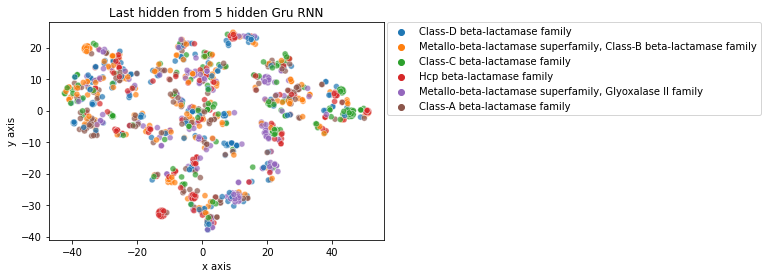

In [ ]:
# visualize pfam 
sns.scatterplot(x=emb_mean2D[:,0], y=emb_mean2D[:,1], alpha=0.7, hue=test_info["Protein families"], legend=True)
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.title("Last hidden from {} hidden Gru RNN".format(hidden_size))
plt.xlabel("x axis")
plt.ylabel("y axis")
plt.savefig("visualization/embedding/{}hidden_{}.png".format(hidden_size, name), bbox_inches="tight")